<a href="https://colab.research.google.com/github/armandoariascastro/NN_for_text_classification/blob/main/Term_Project_ArmandoAriasCastro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#Import libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time
import os
import copy
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
#Read Training file as a dataframe
df = pd.read_csv('train_data.csv', usecols = ['text', 'target'])
data_1 =  copy.deepcopy(df)

Data pre-processing

In [19]:
#Auxiliary functions

#Function to remove punctuation in the text
def punctuation(text):
    trans = str.maketrans("", "", string.punctuation)
    return text.translate(trans)

#Function to remove url adrresses starting with https and www
def url(text):
    addr = re.compile(r"https?://\S+|www\.\S+")
    return addr.sub(r"", text)

#Function to remove stopwords
def stop_words(text):
    word_set = set(stopwords.words('english'))
    no_stopwords = [word.lower() for word in text.split() if word.lower() not in word_set]
    return " ".join(no_stopwords)

#Count the number of unique words in the dataset
from collections import Counter
def word_counter(column):
    counter = Counter()
    for line in column.values:
        for word in line.split():
            counter[word] += 1
    return counter

In [20]:
#Remove urls, punctuation, and stopwords from the training data
data_1["text"] = data_1.text.map(url)
data_1["text"] = data_1.text.map(punctuation)
data_1["text"] = data_1.text.map(stop_words)

In [21]:
#Store all the unique words and the number of unique words
count = word_counter(data_1.text)
number_unique_words = len(count)

In [22]:
#Split training, validation, and test sets
train, val, test = np.split(data_1.sample(frac=1), [int(0.8*len(data_1)), int(0.9*len(data_1))])

#Split sets into text and labels and convert them to numpy arrays
train_text = train.text.to_numpy()
train_labels = train.target.to_numpy()
valid_text = val.text.to_numpy()
valid_labels = val.target.to_numpy()
test_text = test.text.to_numpy()
test_labels = test.target.to_numpy()

In [23]:
#Create a tokenizer
tokenizer = Tokenizer(num_words=number_unique_words)
tokenizer.fit_on_texts(train_text)                      #Fit the tokenizer with the training dataset

#Tokenize all the words in the training, validation, and test datasets
train_sequence = tokenizer.texts_to_sequences(train_text)
valid_sequence = tokenizer.texts_to_sequences(valid_text)
test_sequence = tokenizer.texts_to_sequences(test_text)

In [24]:
#Add padding to the text so they all have the same length.
#Using 25 as the maximum number of words in the sequence
#Missing values are padded with 0
train_text_padded = pad_sequences(train_sequence, maxlen=25, padding='post', truncating='post')
valid_text_padded = pad_sequences(valid_sequence, maxlen=25, padding='post', truncating='post')
test_text_padded = pad_sequences(test_sequence, maxlen=25, padding='post', truncating='post')

Model 1

In [25]:
from keras.src.layers import Dropout
#Create the LSTM model
from keras.src.layers.attention.multi_head_attention import activation
from tensorflow.keras import layers

model = keras.models.Sequential()
model.add(layers.Embedding(number_unique_words, 32, input_length = 25))
model.add(layers.LSTM(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

#Summary of the model showing all layers and number of parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 32)            575072    
                                                                 
 lstm_1 (LSTM)               (None, 128)               82432     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 674145 (2.57 MB)
Trainable params: 67414

In [26]:
#Compile the model
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'])

In [27]:
#Fit the model
history = model.fit(train_text_padded, train_labels, epochs = 10,  validation_data=(valid_text_padded, valid_labels), verbose = 2)

Epoch 1/10
191/191 - 11s - loss: 0.6087 - accuracy: 0.6714 - val_loss: 0.4631 - val_accuracy: 0.7898 - 11s/epoch - 56ms/step
Epoch 2/10
191/191 - 9s - loss: 0.3414 - accuracy: 0.8670 - val_loss: 0.4944 - val_accuracy: 0.7438 - 9s/epoch - 45ms/step
Epoch 3/10
191/191 - 8s - loss: 0.1874 - accuracy: 0.9330 - val_loss: 1.0231 - val_accuracy: 0.7674 - 8s/epoch - 41ms/step
Epoch 4/10
191/191 - 9s - loss: 0.1207 - accuracy: 0.9622 - val_loss: 0.6773 - val_accuracy: 0.7753 - 9s/epoch - 45ms/step
Epoch 5/10
191/191 - 9s - loss: 0.0818 - accuracy: 0.9732 - val_loss: 1.0831 - val_accuracy: 0.7608 - 9s/epoch - 46ms/step
Epoch 6/10
191/191 - 9s - loss: 0.0633 - accuracy: 0.9785 - val_loss: 0.9284 - val_accuracy: 0.7556 - 9s/epoch - 48ms/step
Epoch 7/10
191/191 - 8s - loss: 0.0611 - accuracy: 0.9793 - val_loss: 8.3039 - val_accuracy: 0.7530 - 8s/epoch - 43ms/step
Epoch 8/10
191/191 - 9s - loss: 0.0388 - accuracy: 0.9829 - val_loss: 14.2735 - val_accuracy: 0.7516 - 9s/epoch - 46ms/step
Epoch 9/10
19

Model 2

In [28]:
model_2 = keras.models.Sequential()
model_2.add(layers.Embedding(number_unique_words, 32, input_length=25))
model_2.add(layers.Conv1D(32,3, padding = 'same', activation="relu"))
model_2.add(layers.MaxPooling1D())
model_2.add(layers.Conv1D(64,3,activation="relu"))
model_2.add(layers.MaxPooling1D())
model_2.add(layers.Flatten())
model_2.add(layers.Dense(250,activation="relu"))
model_2.add(layers.Dense(1,activation="sigmoid"))

In [29]:
#Compile the model
model_2.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 32)            575072    
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 32)            3104      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 12, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 320)              

In [30]:
#Fit the model
history_2 = model_2.fit(train_text_padded, train_labels, epochs = 10,  validation_data=(valid_text_padded, valid_labels), verbose = 2)

Epoch 1/10
191/191 - 4s - loss: 0.5761 - accuracy: 0.6897 - val_loss: 0.4760 - val_accuracy: 0.7792 - 4s/epoch - 19ms/step
Epoch 2/10
191/191 - 3s - loss: 0.2709 - accuracy: 0.8957 - val_loss: 0.5154 - val_accuracy: 0.7845 - 3s/epoch - 16ms/step
Epoch 3/10
191/191 - 2s - loss: 0.1144 - accuracy: 0.9603 - val_loss: 0.6474 - val_accuracy: 0.7753 - 2s/epoch - 12ms/step
Epoch 4/10
191/191 - 2s - loss: 0.0702 - accuracy: 0.9770 - val_loss: 0.6834 - val_accuracy: 0.7740 - 2s/epoch - 12ms/step
Epoch 5/10
191/191 - 2s - loss: 0.0502 - accuracy: 0.9831 - val_loss: 0.7574 - val_accuracy: 0.7766 - 2s/epoch - 12ms/step
Epoch 6/10
191/191 - 2s - loss: 0.0404 - accuracy: 0.9846 - val_loss: 0.8134 - val_accuracy: 0.7714 - 2s/epoch - 12ms/step
Epoch 7/10
191/191 - 3s - loss: 0.0346 - accuracy: 0.9849 - val_loss: 0.8294 - val_accuracy: 0.7661 - 3s/epoch - 15ms/step
Epoch 8/10
191/191 - 2s - loss: 0.0300 - accuracy: 0.9862 - val_loss: 0.8474 - val_accuracy: 0.7648 - 2s/epoch - 13ms/step
Epoch 9/10
191/1

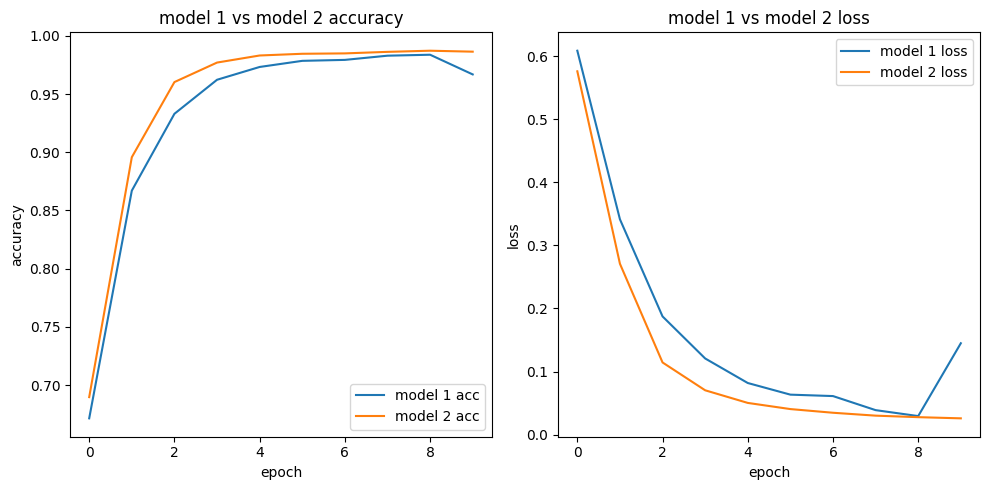

In [31]:
# Summarize history for accuracy model 2
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history_2.history['accuracy'])
plt.title('model 1 vs model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['model 1 acc', 'model 2 acc'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history_2.history['loss'])
plt.title('model 1 vs model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['model 1 loss', 'model 2 loss'])
plt.tight_layout()
plt.show()

In [32]:
test_loss, test_acc = model.evaluate(test_text_padded, test_labels, verbose=0)
test_loss_2, test_acc_2 = model_2.evaluate(test_text_padded, test_labels, verbose=0)
print('Test accuracy model 1:', test_acc)
print('Loss model 1:', test_loss)
print('Test accuracy model 2:', test_acc_2)
print('Loss model 2:', test_loss_2)

Test accuracy model 1: 0.7559055089950562
Loss model 1: 8.958139419555664
Test accuracy model 2: 0.7755905389785767
Loss model 2: 0.9415967464447021
